# Twitter Sentiment Analysis notebook
- Use sentiment anaylsis library to create target variable, Score
- Train multi class logistic regression model

#### Installing libraries

In [3]:

!pip install tweepy

In [4]:
!pip install textblob

In [5]:
!pip install wordcloud


     |████████████████████████████████| 220 kB 775 kB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/25/_g6tp6_j4bz5_bmw9f8k1n5w0000gn/T/pip-install-qhqtjtvs/wordcloud/setup.py'"'"'; __file__='"'"'/private/var/folders/25/_g6tp6_j4bz5_bmw9f8k1n5w0000gn/T/pip-install-qhqtjtvs/wordcloud/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/25/_g6tp6_j4bz5_bmw9f8k1n5w0000gn/T/pip-wheel-uee9p0h1
       cwd: /private/var/folders/25/_g6tp6_j4bz5_bmw9f8k1n5w0000gn/T/pip-install-qhqtjtvs/wordcloud/
  Complete output (24 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.8
  creating build/lib.macosx-10.9-x86_64-3.8/wordcloud
  copying w

### Libraries

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
from datetime import datetime
from pathlib import Path
from itertools import combinations

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import model_selection


import statsmodels.api as sm

from scipy.stats import chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests 

# Tweepy - Python library for accessing the Twitter API.
import tweepy

# TextBlob - Python library for processing textual data
from textblob import TextBlob

# WordCloud - Python linrary for creating image wordclouds
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier # model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

#Regex
import re

%matplotlib inline     
sns.set(color_codes=True)

ModuleNotFoundError: No module named 'wordcloud'

### File Paths

In [ ]:
today                   = datetime.today()
file_path       = Path.cwd() /"covid_vaccine_090721.csv"

### Loading the data into Pandas dataframe

In [7]:
df = pd.read_csv(file_path)
# To display the top 5 rows 
df.head(5) 

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,NSW Multicultural Health Communication Service,NaN,Official account for NSW Multicultural Health ...,2018-08-20 02:00:05,1277,243,2311,True,2021-09-06 23:55:48,“Please get vaccinated. Take COVID seriously. ...,NaN,TweetDeck,False
1,Climate Detective,NaN,Physicist (MA & PhD) & socialist exploring cli...,2020-11-07 17:03:33,94,155,354,False,2021-09-06 23:46:16,@apsmunro That is a lot more than the risk fro...,['CovidVaccine'],Twitter Web App,False
2,david sirias,"Port Townsend, WA",Lefty songwriter/musician/producer/publisher. ...,2011-10-28 20:14:55,1262,1115,489,False,2021-09-06 23:38:34,"As I said months ago, anyone supporting a blan...","['FascistEmployerMandate', 'FascistVaccinePass...",Twitter for iPad,False
3,COVID News,Estados Unidos,News about COVID-19,2013-06-05 08:52:31,3330,1472,130,False,2021-09-06 23:36:50,More crazy Chiropractors!!! This time in Flori...,NaN,Revive Social App,False
4,gain-of-function research,Undr the pine hunting lobsters,@Ayjchan's mandate: 'ONLY look @ a -Leak- frm ...,2013-12-24 20:30:14,272,20,24001,False,2021-09-06 23:29:20,Great 18 point case about why you should not t...,"['CovidVaccine', 'COVIDVaccination']",Twitter for Android,False


___

### Exploratory Data Analysis
Exploratory Data Analysis or (EDA) is understanding the data sets by summarizing their main characteristics often plotting them visually. This step is very important especially when we arrive at modeling the data in order to apply Machine learning. 

In [ ]:
# Data types
df.dtypes

In [ ]:
# Dataframe size (rows, columns)
df.shape

In [ ]:
# Missing count per column
print(df.isnull().sum())

In [ ]:
df.head(5) 

In [ ]:
# Unique strings in MD5 count
df['source'].value_counts()

In [ ]:
plt.figure(figsize = (16,5))
ax = sns.countplot(x='user_verified', data=df)

___

### Data Cleaning/Feature Engineering:

Before we start our sentiment analysis it is a good idea to clean up each tweets from an unnecessary data first.

We are going to create a cleanUpTweet function that will:

remove mentions
remove hashtags
remove retweets
remove urls

In [14]:
def cleanUpTweet(txt):
    # Remove mentions
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    # Remove hashtags
    txt = re.sub(r'#', '', txt)
    # Remove retweets:
    txt = re.sub(r'RT : ', '', txt)
    # Remove urls
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt)
    return txt

And nw we are going to apply it for all the Tweets in our Pandas Data Frame.



In [15]:
df['Tweet'] = df['text'].apply(cleanUpTweet)

In [16]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Tweet
0,NSW Multicultural Health Communication Service,NaN,Official account for NSW Multicultural Health ...,2018-08-20 02:00:05,1277,243,2311,True,2021-09-06 23:55:48,“Please get vaccinated. Take COVID seriously. ...,NaN,TweetDeck,False,“Please get vaccinated. Take COVID seriously. ...
1,Climate Detective,NaN,Physicist (MA & PhD) & socialist exploring cli...,2020-11-07 17:03:33,94,155,354,False,2021-09-06 23:46:16,@apsmunro That is a lot more than the risk fro...,['CovidVaccine'],Twitter Web App,False,That is a lot more than the risk from the Cov...
2,david sirias,"Port Townsend, WA",Lefty songwriter/musician/producer/publisher. ...,2011-10-28 20:14:55,1262,1115,489,False,2021-09-06 23:38:34,"As I said months ago, anyone supporting a blan...","['FascistEmployerMandate', 'FascistVaccinePass...",Twitter for iPad,False,"As I said months ago, anyone supporting a blan..."
3,COVID News,Estados Unidos,News about COVID-19,2013-06-05 08:52:31,3330,1472,130,False,2021-09-06 23:36:50,More crazy Chiropractors!!! This time in Flori...,NaN,Revive Social App,False,More crazy Chiropractors!!! This time in Flori...
4,gain-of-function research,Undr the pine hunting lobsters,@Ayjchan's mandate: 'ONLY look @ a -Leak- frm ...,2013-12-24 20:30:14,272,20,24001,False,2021-09-06 23:29:20,Great 18 point case about why you should not t...,"['CovidVaccine', 'COVIDVaccination']",Twitter for Android,False,Great 18 point case about why you should not t...


### Target Variable

- We will use sentiment analysis to create our target variable, Score. The values will be negative, positive, and neutral

We are also going to build a couple more functions to calculate the subjectivity and polarity of our tweets.



In [17]:
def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity

And now we are going to apply these functions to our data frame and create two new features in our data frame Subjectivity and Polarity.



In [18]:
df['Subjectivity'] = df['Tweet'].apply(getTextSubjectivity)
df['Polarity'] = df['Tweet'].apply(getTextPolarity)

In [19]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Tweet,Subjectivity,Polarity
0,NSW Multicultural Health Communication Service,NaN,Official account for NSW Multicultural Health ...,2018-08-20 02:00:05,1277,243,2311,True,2021-09-06 23:55:48,“Please get vaccinated. Take COVID seriously. ...,NaN,TweetDeck,False,“Please get vaccinated. Take COVID seriously. ...,0.333333,0.083333
1,Climate Detective,NaN,Physicist (MA & PhD) & socialist exploring cli...,2020-11-07 17:03:33,94,155,354,False,2021-09-06 23:46:16,@apsmunro That is a lot more than the risk fro...,['CovidVaccine'],Twitter Web App,False,That is a lot more than the risk from the Cov...,0.750000,0.250000
2,david sirias,"Port Townsend, WA",Lefty songwriter/musician/producer/publisher. ...,2011-10-28 20:14:55,1262,1115,489,False,2021-09-06 23:38:34,"As I said months ago, anyone supporting a blan...","['FascistEmployerMandate', 'FascistVaccinePass...",Twitter for iPad,False,"As I said months ago, anyone supporting a blan...",0.250000,0.250000
3,COVID News,Estados Unidos,News about COVID-19,2013-06-05 08:52:31,3330,1472,130,False,2021-09-06 23:36:50,More crazy Chiropractors!!! This time in Flori...,NaN,Revive Social App,False,More crazy Chiropractors!!! This time in Flori...,0.700000,-0.250000
4,gain-of-function research,Undr the pine hunting lobsters,@Ayjchan's mandate: 'ONLY look @ a -Leak- frm ...,2013-12-24 20:30:14,272,20,24001,False,2021-09-06 23:29:20,Great 18 point case about why you should not t...,"['CovidVaccine', 'COVIDVaccination']",Twitter for Android,False,Great 18 point case about why you should not t...,0.750000,0.800000


We have some empty rows here so before further processing let's remove those.

The below command will remove all the rows with the Tweet column equals to "".

In [20]:
df = df.drop(df[df['Tweet'] == ''].index)


In [21]:
# negative, nautral, positive analysis
def getTextAnalysis(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"

And apply this functiona and create another feature in our data frame called Score.


In [22]:
df['Score'] = df['Polarity'].apply(getTextAnalysis)

Let;s now take all positive tweets and calculate the percentage of positive tweets from all the tweets in our data frame.



In [23]:
positive = df[df['Score'] == 'Positive']

print(str(positive.shape[0]/(df.shape[0])*100) + " % of positive tweets")

41.398133474203206 % of positive tweets


We can now visualise positive, negative, neutral tweets using Matplotlib.


<BarContainer object of 3 artists>

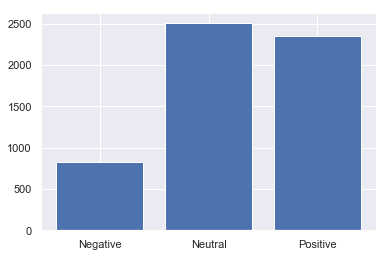

In [24]:
labels = df.groupby('Score').count().index.values

values = df.groupby('Score').size().values

plt.bar(labels, values)

_______________

___

### Splitting Dataset into Train and Test

The splitting methodology implemented is to split the datasets based on years. The aim is to get an industry standard sample split of 80% train and 20% test

In [26]:
row_count = len(df)
print('row count: ', row_count)

row count:  5679


#### Missing value treatment

In [27]:
values = {"user_location": 'None', "user_description": 'None', "hashtags": 'None'}
df.fillna(value=values, inplace = True)

In [28]:
# Missing count per column
print(df.isnull().sum())

user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
is_retweet          0
Tweet               0
Subjectivity        0
Polarity            0
Score               0
dtype: int64


#### One Hot Encoding
One hot encoding creates new (binary) columns, indicating the presence of each possible value from the original data.

In [29]:
# List of columns to be one hot encoded
ONE_HOT_ENCODED_COLUMNS = ['source', 'user_verified', 'is_retweet']

In [30]:
encoder=OneHotEncoder(sparse=False)
df_merged_encoded = df.copy()

for column_name in ONE_HOT_ENCODED_COLUMNS:
    X_encoded          = pd.DataFrame (encoder.fit_transform(df_merged_encoded[[column_name]]))
    X_encoded.columns  = encoder.get_feature_names([column_name])
    df_merged_encoded = pd.concat([df_merged_encoded, X_encoded ], axis=1)

In [31]:
df_merged_encoded.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'Tweet',
       'Subjectivity', 'Polarity', 'Score', 'source_@healthpolicyw',
       'source_Agorapulse app', 'source_Ai News Room',
       'source_Blog2Social APP', 'source_Buffer',
       'source_Canada Vaccine Tracker', 'source_Canva',
       'source_Cloud Campaign', 'source_CoSchedule',
       'source_ContentCal Studio', 'source_CrowdControlHQ',
       'source_Crowdfire App', 'source_Daily Voice Sync', 'source_Echobox',
       'source_Falcon Social Media Management ', 'source_Flying Eze',
       'source_Grabyo', 'source_HeyOrca', 'source_Hocalwire Social Share',
       'source_Hootsuite Inc.', 'source_HubSpot', 'source_Instagram',
       'source_Ireland Vaccine Progress', 'source_Khoros Publishing App',
       'source_LaterMedia', 'source_Loomly', 'source_Meltwater Social',
  

In [32]:
X_Features = ['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'Tweet',
       'Subjectivity', 'Polarity', 'source_@healthpolicyw',
       'source_Agorapulse app', 'source_Ai News Room',
       'source_Blog2Social APP', 'source_Buffer',
       'source_Canada Vaccine Tracker', 'source_Canva',
       'source_Cloud Campaign', 'source_CoSchedule',
       'source_ContentCal Studio', 'source_CrowdControlHQ',
       'source_Crowdfire App', 'source_Daily Voice Sync', 'source_Echobox',
       'source_Falcon Social Media Management ', 'source_Flying Eze',
       'source_Grabyo', 'source_HeyOrca', 'source_Hocalwire Social Share',
       'source_Hootsuite Inc.', 'source_HubSpot', 'source_Instagram',
       'source_Ireland Vaccine Progress', 'source_Khoros Publishing App',
       'source_LaterMedia', 'source_Loomly', 'source_Meltwater Social',
       'source_Microsoft Power Platform', 'source_National Herald',
       'source_Nonli', 'source_Oktopost', 'source_Orlo', 'source_Oyeyeah',
       'source_OzVaxProgress', 'source_Paper.li', 'source_PromoRepublic',
       'source_Publer.io', 'source_Restream.io', 'source_RetweetsMumbaiOne',
       'source_Revive Social App', 'source_SOCi - Simplifying Social Media',
       'source_SPTK: DVBergen', 'source_Salesforce - Social Studio',
       'source_Sendible', 'source_Sharpspring', 'source_Sked Social',
       'source_SmarterQueue', 'source_Spreaker', 'source_Sprinklr',
       'source_Sprinklr Publishing', 'source_Sprout Social',
       'source_The Healthsite', 'source_The Social Jukebox',
       'source_Tweet Suite', 'source_TweetDeck', 'source_Tweetbot for iΟS',
       'source_Twitter Ads', 'source_Twitter Media Studio',
       'source_Twitter Media Studio - LiveCut', 'source_Twitter Web App',
       'source_Twitter for Advertisers', 'source_Twitter for Advertisers.',
       'source_Twitter for Android', 'source_Twitter for Mac',
       'source_Twitter for iPad', 'source_Twitter for iPhone',
       'source_UKVacTrack', 'source_UKVaccineStats', 'source_VaxBlr',
       'source_WECAN Content', 'source_WordPress.com', 'source_Zoho Social',
       'source_dlvr.it', 'source_eClincher', 'source_pluspora',
       'source_recurpost.com', 'source_robly_marketing', 'source_todayinnevada', 'source_vaccinate chicago',
       'source_vaccinebotuk', 'user_verified_False', 'user_verified_True',
       'is_retweet_False'
       ]

Target = 'Score'

In [33]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_merged_encoded[X_Features], df_merged_encoded[Target], test_size=0.20, random_state=4)

x_train.reset_index(drop=True, inplace= True)
x_test.reset_index(drop=True, inplace= True)
y_train.reset_index(drop=True, inplace= True)
y_test.reset_index(drop=True, inplace= True)

In [34]:
print('Train size : ',len(x_train))

Train size :  4543


In [35]:
print('Test size : ',len(x_test))

Test size :  1136


___

# Task 2: Machine Learning Model

### Goal:

The purpose of this model building exercise is to build a binary classification model that can identify whether sentiment.

### Steps:
1. Model Train
2. Error Analysis


## Model Training

In [36]:
MODELING_FEATURES = ['source_@healthpolicyw',
       'source_Agorapulse app', 'source_Ai News Room',
       'source_Blog2Social APP', 'source_Buffer',
       'source_Canada Vaccine Tracker', 'source_Canva',
       'source_Cloud Campaign', 'source_CoSchedule',
       'source_ContentCal Studio', 'source_CrowdControlHQ',
       'source_Crowdfire App', 'source_Daily Voice Sync', 'source_Echobox',
       'source_Falcon Social Media Management ', 'source_Flying Eze',
       'source_Grabyo', 'source_HeyOrca', 'source_Hocalwire Social Share',
       'source_Hootsuite Inc.', 'source_HubSpot', 'source_Instagram',
       'source_Ireland Vaccine Progress', 'source_Khoros Publishing App',
       'source_LaterMedia', 'source_Loomly', 'source_Meltwater Social',
       'source_Microsoft Power Platform', 'source_National Herald',
       'source_Nonli', 'source_Oktopost', 'source_Orlo', 'source_Oyeyeah',
       'source_OzVaxProgress', 'source_Paper.li', 'source_PromoRepublic',
       'source_Publer.io', 'source_Restream.io', 'source_RetweetsMumbaiOne',
       'source_Revive Social App', 'source_SOCi - Simplifying Social Media',
       'source_SPTK: DVBergen', 'source_Salesforce - Social Studio',
       'source_Sendible', 'source_Sharpspring', 'source_Sked Social',
       'source_SmarterQueue', 'source_Spreaker', 'source_Sprinklr',
       'source_Sprinklr Publishing', 'source_Sprout Social',
       'source_The Healthsite', 'source_The Social Jukebox',
       'source_Tweet Suite', 'source_TweetDeck', 'source_Tweetbot for iΟS',
       'source_Twitter Ads', 'source_Twitter Media Studio',
       'source_Twitter Media Studio - LiveCut', 'source_Twitter Web App',
       'source_Twitter for Advertisers', 'source_Twitter for Advertisers.',
       'source_Twitter for Android', 'source_Twitter for Mac',
       'source_Twitter for iPad', 'source_Twitter for iPhone',
       'source_UKVacTrack', 'source_UKVaccineStats', 'source_VaxBlr',
       'source_WECAN Content', 'source_WordPress.com', 'source_Zoho Social',
       'source_dlvr.it', 'source_eClincher', 'source_pluspora',
       'source_recurpost.com', 'source_robly_marketing', 'source_todayinnevada', 'source_vaccinate chicago',
       'source_vaccinebotuk', 'user_verified_False', 'user_verified_True',
       'is_retweet_False', 'user_followers', 'user_friends', 'user_favourites']
len(MODELING_FEATURES)

86

### Logistic Regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable

In [6]:
lg_model = LogisticRegression()
lg_model.fit(x_train[MODELING_FEATURES], y_train)

NameError: name 'LogisticRegression' is not defined

___

### Error Analysis

In [39]:
lg_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
# Predict on test dataset
y_pred = lg_model.predict(x_test[MODELING_FEATURES])

In [41]:
# Peformance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4198943661971831


In [44]:
print(metrics.classification_report(y_test, lg_model.predict(x_test[MODELING_FEATURES])))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       161
     Neutral       0.48      0.13      0.21       516
    Positive       0.41      0.89      0.56       459

   micro avg       0.42      0.42      0.42      1136
   macro avg       0.30      0.34      0.26      1136
weighted avg       0.39      0.42      0.32      1136



C:\Users\hamsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hamsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hamsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Feature Importance

In [42]:
feature_importance=pd.DataFrame({'feature':list(x_test[MODELING_FEATURES].columns),'feature_importance':[abs(i) for i in lg_model.coef_[0]]})
feature_importance.sort_values('feature_importance',ascending=False)

,feature,feature_importance
82,is_retweet_False,3.171878e-01
80,user_verified_False,2.920024e-01
62,source_Twitter for Android,7.625968e-02
59,source_Twitter Web App,6.780480e-02
65,source_Twitter for iPhone,5.750852e-02
68,source_VaxBlr,4.797531e-02
81,user_verified_True,2.518541e-02
39,source_Revive Social App,2.205498e-02
19,source_Hootsuite Inc.,1.291590e-02
54,source_TweetDeck,9.781095e-03
